[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Environmental space definition for global hydrogen production**
<!-- **<div style="text-align: left; font-size: 19px;"> Environmental space definition for global hydrogen production**</div> -->

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>


# **0. Initialisation**

In [1]:
using CSV,DataFrames,XLSX,Statistics, Interpolations
using LinearAlgebra,SparseArrays, Distributions, KernelDensity
using JLD2
import Statistics: quantile
using Logging
global_logger(NullLogger())
include("Utils/2_02_utils.jl");
xr = pyimport("xarray");


Reading AR6 scenarios...
Reading remind scenarios...
Reading IMAGE SSP2-1.9 scenarios...
Reading IMAGE SSP2-1.9new scenarios...
Reading...
past...
Reading tiam-ucl scenarios...


In [2]:
function quantile(a::Matrix{Float64}, q::Float64; dims::Int64)
    return mapslices(x -> quantile(x, q), a; dims=dims) |> vec
end


quantile (generic function with 81 methods)

In [3]:
### Target setting
target=2.25 #W/m² by 2100

## We make this initial filter based on the AR6 report - A.III.I.11 Comparison of Mitigation and Removal Measures Represented by Models that Contributed Mitigation Scenarios to the Assessment - Table 7 | Overview of demand- and supply-side mitigation and removal measures in the energy, transport, building, industry and AFOLU sectors, as stated by contributing modelling teams to the AR6 database.

## models with a comprhensive hydrogen production pathways (explicit and endogenous):
accepted_mods=["REMIND","MESSAGEix-GLOBIOM","POLES",
            "IMAGE","PROMETHEUS","TIAM","REmap",
            "COFFEE","EPPA","McKinsey","GCAM","GMM"]

## rejected scenarios based on insufficient data granularity.
rejected_scenarios=["EMF33",
                    "CD-LINKS",
                    "SSP1-19",
                    "SSP2-19",
                    "SSP5-19",
                    "R_MAC_35_n8",
                    "R_MAC_30_n8",
                    "EN_NPi2020_200f",
                    "EN_NPi2020_300f",
                    "EN_NPi2020_400f",
                    "SSP2_openres_lc_120",
                    "SSP2_openres_lc_CB400",
                    "SSP2_openres_lc_CB450",
                    "SSP2_openres_lc_CB500",
                    "SSP2_openres_lc_CB550",
                    "SSP2_openres_lc_CB600",
                    "EMF30_ClimPolicy",
                    "EMF30_ClimPolicy+SLCF",
                    "EMF30_Slower-to-faster",
                    "EMF30_Slower-to-faster+SLCF",
                    "EMF30_Slower-to-faster+SLCF+HFC"]

df = AR6database_formating(target; accepted_models=accepted_mods, rejected_scenarios=rejected_scenarios);


In [10]:
# filter(row -> row[:Model] == Model, df)
# df

writetable(unique(df[!,["Model","Scenario","Variable"]]); worksheet="Model_Scenarios",workbook="output.xlsx")



In [4]:
getModel(df)


Row,Model,Scenario
,Any,Any
1,GCAM 5.3,NGFS2_Divergent Net Zero Policies
2,IMAGE 3.0.1,IMA15-AGInt
3,IMAGE 3.0.1,IMA15-Def
4,IMAGE 3.0.1,IMA15-Eff
5,IMAGE 3.0.1,IMA15-LiStCh
6,IMAGE 3.0.1,IMA15-LoNCO2
7,IMAGE 3.0.1,IMA15-Pop
8,IMAGE 3.0.1,IMA15-RenElec
9,IMAGE 3.0.1,IMA15-TOT


In [4]:
getModel(df)


Row,Model,Scenario
,Any,Any
1,GCAM 5.3,NGFS2_Divergent Net Zero Policies
2,IMAGE 3.0.1,IMA15-AGInt
3,IMAGE 3.0.1,IMA15-Def
4,IMAGE 3.0.1,IMA15-Eff
5,IMAGE 3.0.1,IMA15-LiStCh
6,IMAGE 3.0.1,IMA15-LoNCO2
7,IMAGE 3.0.1,IMA15-Pop
8,IMAGE 3.0.1,IMA15-RenElec
9,IMAGE 3.0.1,IMA15-TOT


In [5]:
img_SSP2[end,:]


Row,Model,Scenario,Region,Variable,Unit,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2060,2070,2080,2090,2100
,String7,String31,String7,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
23116,IMAGE,SSP2_SPA0_19I_CP,WEU,Production|Industry|Iron and Steel|Primary,Mtonne/yr,99.0358,87.6759,81.5083,68.6403,63.0079,59.4626,68.5645,75.5355,78.7467,80.0751,72.5639,60.0155,55.3807,55.1132,53.0377


In [6]:
function add_secondary_energy_rows(df::DataFrame)

    sec = DataFrame(df[1:0,:])   # empty clone for new rows
    for sub in groupby(df, [:Model, :Scenario])
        # println("Processing Model: ", sub.Model[1], ", Scenario: ", sub.Scenario[1])
        # # skip if they already have a top‑level Secondary Energy
        if any(sub.Variable .== "Secondary Energy")
            continue
        end
        # pick only those detail rows "Secondary Energy|x" with exactly one '|'
        detail = filter(r -> startswith(r.Variable, "Secondary Energy|") &&
                             count(==('|'), r.Variable) == 1,
                        sub)

        if isempty(detail)
            detail = filter(r -> startswith(r.Variable, "Secondary Energy|") &&
                             count(==('|'), r.Variable) == 2,
                        sub)
            isempty(detail) && continue  # nothing to sum? skip
        end

        temp=DataFrame(sub[end,:])
        cols=names(temp)
        temp_meta = Matrix(copy(temp[:, 1:5]))
        temp_meta[:,4] .= "Secondary Energy"  # set Variable to "Secondary Energy"
        temp_meta[:,5] .= "EJ/yr"  # set Unit to "EJ/yr"
        # 1) interpolate any missing in‑place
        temp_data = detail[:, 6:end]|> fill_missing!  
        temp_data  = Float64.(Matrix(temp_data))
        temp_data  = sum(temp_data; dims=1)
        temp_app=hcat(temp_meta,temp_data)
        temp_rows = DataFrame(temp_app,cols)
        sec=vcat(sec, temp_rows; cols = :union)
    end
    return sec
end


add_secondary_energy_rows (generic function with 1 method)

In [43]:
getVals("Secondary Energy|Electricity|Hydro",df=df)./getVals("Secondary Energy",df=df)


43×81 Matrix{Float64}:
 0.0459253  0.0478552  0.0499278  …  0.121727    0.120578    0.11946
 0.0461399  0.0473912  0.0486804     0.0536245   0.0533214   0.0530214
 0.0461401  0.0473907  0.0486793     0.0541546   0.0538516   0.0535519
 0.0469893  0.0484109  0.0498838     0.0614837   0.0612521   0.0610234
 0.0468398  0.048251   0.0497131     0.0559491   0.0557001   0.0554538
 0.0461399  0.0473912  0.0486804  …  0.0539738   0.0537918   0.0536118
 0.0462002  0.0474796  0.0487994     0.0686928   0.0688294   0.0689659
 0.0459905  0.0474229  0.0489042     0.0387158   0.038653    0.0385911
 0.0461423  0.0476849  0.0492899     0.0544107   0.0546836   0.054955
 0.0457522  0.0459269  0.0460978     0.0448768   0.044353    0.0438327
 ⋮                                ⋱                          ⋮
 0.038769   0.0410046  0.0432465     0.036989    0.036822    0.0366572
 0.0423351  0.0436091  0.0448875  …  0.0708143   0.0710527   0.0712933
 0.0449288  0.046139   0.0473606     0.0560998   0.0561423   0.05

43×81 Matrix{Float64}:
 315.511  304.636  293.762  282.888  272.013  …   175.647   178.024   180.402
 340.683  335.667  330.652  325.636  320.621      470.57    473.07    475.569
 340.681  335.661  330.641  325.621  320.601      469.664   472.279   474.893
 332.225  326.429  320.632  314.836  309.039      420.843   423.4     425.956
 334.479  328.659  322.838  317.017  311.196      450.795   453.196   455.597
 340.683  335.667  330.652  325.636  320.621  …   468.22    470.879   473.538
 339.715  334.52   329.325  324.13   318.934      382.287   382.363   382.438
 339.03   333.425  327.819  322.214  316.608      580.875   585.079   589.283
 339.209  332.615  326.022  319.428  312.834      440.509   441.698   442.886
 346.642  350.565  354.489  358.413  362.336      450.235   451.776   453.317
   ⋮                                          ⋱                         ⋮
 441.11   440.495  439.881  439.266  438.652      918.425   924.449   930.472
 434.099  433.347  432.594  431.842  431.09  

# **1. Future hydrogen production**

In [7]:
SEʰ²=getVals("Secondary Energy|Hydrogen",df=df)
ṁᵏᵍ=SEʰ².*EJH2_to_kgH2 # mass H2
ṁᴹᵗ=ṁᵏᵍ.*1e-9; # convert to Mt
ṁᴳᵗ=ṁᴹᵗ.*1e-3;


In [8]:
ṁᴹᵗ


43×81 Matrix{Float64}:
 0.120708    0.163716    0.206724    …   140.236   141.172   142.108
 0.0156301   0.0657802   0.11593         435.386   443.204   451.022
 0.0156301   0.0657803   0.11593         467.359   474.435   481.51
 0.0121839   0.0591668   0.10615         510.861   518.171   525.481
 0.0222769   0.0858236   0.14937         401.36    410.761   420.162
 0.0156301   0.0657802   0.11593     …   407.607   417.588   427.57
 0.0156951   0.0661603   0.116625        365.043   369.46    373.878
 0.015591    0.0584482   0.101305        649.771   660.146   670.522
 0.010903    0.0597798   0.108657        541.12    545.839   550.558
 1.26172e-8  1.30592e-8  1.35011e-8      606.916   620.434   633.951
 ⋮                                   ⋱                         ⋮
 3.18699     3.6517      4.11641         520.375   524.307   528.239
 4.11291     4.80098     5.48905     …   387.742   389.163   390.584
 4.14625     5.58556     7.02487         531.429   534.006   536.584
 3.91017     6.29

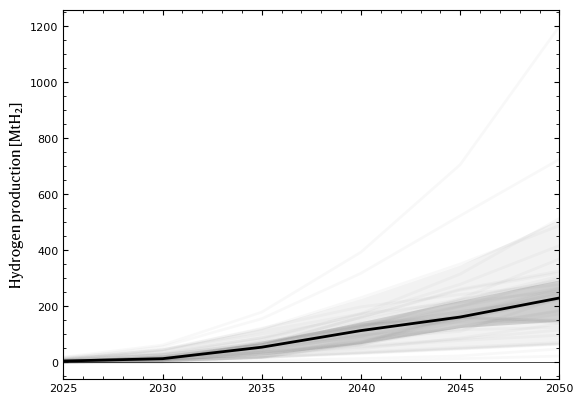

In [9]:
fig, axs = plt.subplots()
years=2025:5:2050
year_index=years.-2019 
ṁᴹᵗq05=quantile(ṁᴹᵗ[:,year_index],0.05,dims=1)'
ṁᴹᵗq25=quantile(ṁᴹᵗ[:,year_index],0.25,dims=1)'
ṁᴹᵗq50=median(ṁᴹᵗ[:,year_index],dims=1)'
ṁᴹᵗq75=quantile(ṁᴹᵗ[:,year_index],0.75,dims=1)'
ṁᴹᵗq95=quantile(ṁᴹᵗ[:,year_index],0.95,dims=1)'
axs.plot(years,ṁᴹᵗ[:,year_index]',linewidth=2,color="grey",alpha=0.05)
axs.plot(years,ṁᴹᵗq50,linewidth=2,color="k",label="Model ensemble")
axs.fill_between(x=years, y1=ṁᴹᵗq05, y2=ṁᴹᵗq95, color="grey",linewidth=0, alpha=0.1) #85% proba
axs.fill_between(x=years, y1=ṁᴹᵗq25, y2=ṁᴹᵗq75, color="grey",linewidth=0, alpha=0.3) #70% proba
axs.set_xlim(2025, 2050)
axs.set_ylabel("Hydrogen production [MtH₂]",fontproperties=font_prop_labels)
axs.axhline(0, color="k", linewidth=0.5)
display(plt.gcf())
plt.close("all")


# **2. Estimating the allocation factor for hydrogen production**


## **2.1. Emission based allocation** 

In [10]:
Emi=getVals("Emissions|CO2|Gross",df=df);
Emiˢᵉ=getVals("Emissions|CO2|Gross|Energy|Supply",df=df);
αᵉᵐⁱ=Emiˢᵉ./Emi;


## **2.2. utilitarian principle** 

In [11]:
SE=getVals("Secondary Energy",df=df)
αˢᵉ=SEʰ²./SE;
α=αᵉᵐⁱ.*αˢᵉ
αᵏᵍ=α./ṁᵏᵍ;
αᴹᵗ=α./ṁᴹᵗ;
αᴳᵗ=α./ṁᴳᵗ;


remind scenarios

In [12]:
rmd_df=filter(s -> s[:Scenario] == "SSP1-PkBudg500" ||
                    s[:Scenario] == "SSP2EU-PkBudg500" ||
                    s[:Scenario] == "SSP5-PkBudg500" ||
                    s[:Scenario] == "SSP1-PkBudg650" ||
                    s[:Scenario] == "SSP2-PkBudg650" ||
                    s[:Scenario] == "SSP2-EU21-PkBudg650"
                    , df);
                    
emiʰ²_rmd=getVals("Emissions|CO2|Gross|Energy|Supply|Hydrogen",df=rmd_df);
emiˢᵉ_rmd=getVals("Emissions|CO2|Gross|Energy|Supply",df=rmd_df);
emi_rmd=getVals("Emissions|CO2|Gross",df=rmd_df);
SE_rmd=getVals("Secondary Energy",df=rmd_df)
SEʰ²_rmd=getVals("Secondary Energy|Hydrogen",df=rmd_df)

ṁᵏᵍ_rmd=(SEʰ²_rmd.*EJH2_to_kgH2)# mass H2
ṁᴹᵗ_rmd=ṁᵏᵍ_rmd.*1e-9; # convert to Mt
ṁᴳᵗ_rmd=ṁᴹᵗ_rmd.*1e-3;  

β_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)
βᵏᵍ_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)./ṁᵏᵍ_rmd
βᴹᵗ_rmd= (emiˢᵉ_rmd./emi_rmd).*(SEʰ²_rmd./SE_rmd)./ṁᴹᵗ_rmd
γᵏᵍ_rmd= (emiʰ²_rmd./emi_rmd)./ṁᵏᵍ_rmd;


## **2.3. Economic allocation testing** 

In [13]:
lifetimes=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Lifetime"
                                "Tech|Hydrogen|Biomass|w/o CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/ CC|Lifetime"
                                "Tech|Hydrogen|Coal|w/o CC|Lifetime"
                                "Tech|Hydrogen|Electricity|Lifetime"
                                "Tech|Hydrogen|Gas|w/ CC|Lifetime"
                                "Tech|Hydrogen|Gas|w/o CC|Lifetime"]] #yr

capex=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs"]] #US$/kW

annual_capex=[i./j for (i,j) ∈ zip(capex,lifetimes)] #US$/kW/yr


capex_adj=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Biomass|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Coal|w/o CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Electricity|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/ CC|Capital Costs|w/ Adj Costs"
                                "Tech|Hydrogen|Gas|w/o CC|Capital Costs|w/ Adj Costs"]]

annual_capex_adj=[i./j for (i,j) ∈ zip(capex_adj,lifetimes)] #US$/kW/yr

opex_fixed=[getVals(i,df=rmd_df) for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Biomass|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Coal|w/o CC|OM Cost|fixed"
                                "Tech|Hydrogen|Electricity|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/ CC|OM Cost|fixed"
                                "Tech|Hydrogen|Gas|w/o CC|OM Cost|fixed"]] #US$/kW/yr


opex_var=[getVals(i,df=rmd_df).*31.536 for i ∈  ["Tech|Hydrogen|Biomass|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Biomass|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Coal|w/o CC|OM Cost|variable"
                                        "Tech|Hydrogen|Electricity|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/ CC|OM Cost|variable"
                                        "Tech|Hydrogen|Gas|w/o CC|OM Cost|variable"]] #US$/kW/yr
;

total_costs= [a.+b.+c for (a,b,c) ∈ zip(annual_capex,opex_fixed,opex_var)] #US$/kW/yr

total_costs=total_costs[1].+total_costs[2].+total_costs[3].+total_costs[4].+total_costs[5].+total_costs[6].+total_costs[7]


6×81 Matrix{Float64}:
 1367.43  1327.52  1287.62  1247.71  1207.8   …   916.426   915.636   914.846
 1367.43  1326.49  1285.55  1244.61  1203.67      922.38    922.307   922.235
 1367.43  1326.68  1285.92  1245.16  1204.41      918.662   918.592   918.521
 1889.7   1830.02  1770.35  1710.67  1650.99     1291.63   1291.52   1291.42
 1889.7   1830.02  1770.35  1710.67  1650.99     1118.17   1117.89   1117.61
 1868.59  1810.39  1752.18  1693.98  1635.78  …  1101.74   1101.41   1101.08

In [14]:
GDP=getVals("GDP|PPP",df=rmd_df)
αᵏᵍ_gdp= total_costs./GDP./ṁᵏᵍ_rmd


6×81 Matrix{Float64}:
 3.18451e-12  1.85058e-12  1.25652e-12  …  2.62995e-15  2.59704e-15
 3.18451e-12  1.76262e-12  1.17321e-12     1.06197e-15  1.03147e-15
 3.18451e-12  1.70824e-12  1.12291e-12     1.38931e-16  1.3577e-16
 3.5216e-12   2.93519e-12  2.47759e-12     3.14567e-15  3.09187e-15
 3.5216e-12   2.93519e-12  2.47759e-12     3.2122e-15   3.1305e-15
 3.40423e-12  2.84577e-12  2.40808e-12  …  3.13379e-15  3.05383e-15

## **2.4 Comparison of allocation factors**

In this section, we use the results derived from the analysis in the [AR6.ipynb](AR6.ipynb) notebook. 

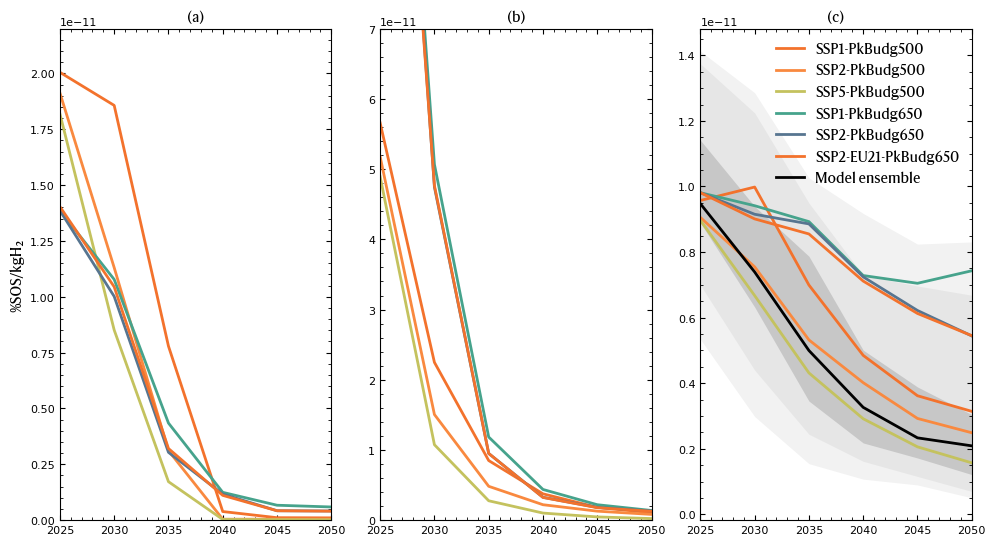

In [15]:
# rcParams["axes.prop_cycle"] = plt.cycler("color",["#e32f27"
#                                                 "#fca082"
#                                                 "#3787c0"]);
years=2025:5:2050
year_index=years.-2019 

fig, axs = plt.subplots(1,3,figsize=(10, 5.5))#,figsize=(12,7)
# ax.figure.set_facecolor("white")

## Remind emission based allocation
axs[1].set_title("(a)",fontproperties=font_prop_labels)
axs[1].plot(years,γᵏᵍ_rmd[:,year_index]'.*100,linewidth=2)
axs[1].set_ylabel("%SOS/kgH₂",fontproperties=font_prop_labels)
axs[1].set_ylim(0, 2.2e-13*100)
axs[1].set_xlim(2025, 2050)


## Remind economic allocation
axs[2].set_title("(b)",fontproperties=font_prop_labels)
axs[2].plot(years,αᵏᵍ_gdp[:,year_index]'.*100,linewidth=2)
axs[2].set_ylim(0, 7e-13*100)
axs[2].set_xlim(2025, 2050)

# allocated space per kgH2 using utilitarian principle.
axs[3].set_title("(c)",fontproperties=font_prop_labels)
αᵏᵍmins = [minimum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αᵏᵍmaxs = [maximum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αq(a,q) = [quantile(filter(!isnan, a[:,j]), q ) for j in 1:size(a,2)][year_index]
αᵏᵍq05 , αᵏᵍq95 = αq(αᵏᵍ,0.05),αq(αᵏᵍ,0.95) #5-95th (90%) IQR 
αᵏᵍq25 , αᵏᵍq75 = αq(αᵏᵍ,0.25),αq(αᵏᵍ,0.75) #25-75th (50%) IQR
# αᵏᵍq40 , αᵏᵍq60 = αq(αᵏᵍ,0.40),αq(αᵏᵍ,0.60); #40-60th (20%) IQR
# αᵏᵍq10 = αq(αᵏᵍ,0.10); #40-60th (20%) IQR
αᵏᵍq50 = αq(αᵏᵍ,0.50)

# axs[3].plot(years,αᵏᵍ[:,year_index]',linewidth=2, color="grey",alpha=0.3)
axs[3].plot(years,βᵏᵍ_rmd[:,year_index]'.*100,label=["SSP1-PkBudg500",
                                                    "SSP2-PkBudg500",
                                                    "SSP5-PkBudg500",
                                                    "SSP1-PkBudg650",
                                                    "SSP2-PkBudg650",
                                                    "SSP2-EU21-PkBudg650"],linewidth=2)
axs[3].plot(years,αᵏᵍq50.*100  ,label="Model ensemble",linewidth=2, color="k")
axs[3].fill_between(x=years, y1=αᵏᵍmins.*100, y2=αᵏᵍmaxs.*100, color="grey",linewidth=0, alpha=0.1)
axs[3].fill_between(x=years, y1=αᵏᵍq05.*100, y2=αᵏᵍq95.*100, color="grey",linewidth=0, alpha=0.1) #85% proba
axs[3].fill_between(x=years, y1=αᵏᵍq25.*100, y2=αᵏᵍq75.*100, color="grey",linewidth=0, alpha=0.3) #70% proba
axs[3].set_xlim(2025, 2050)


plt.tight_layout()
plt.legend(frameon=false,prop=font_prop_labels)
plt.savefig(respath*"/SI_Fig3.svg",transparent=true)
plt.savefig(respath*"/SI_Fig3.png",dpi=800,transparent=true)
display(plt.gcf())
plt.close("all")


## **2.5. Scenario results**

Next, we want to increase the interpolation to go from 5 years to 1 year step so cummulative emissions would render properly. We will simply use the `highres` function available in the supplementary variables. To avoid overcomplicating, we will just repeat what we did before with that function. 

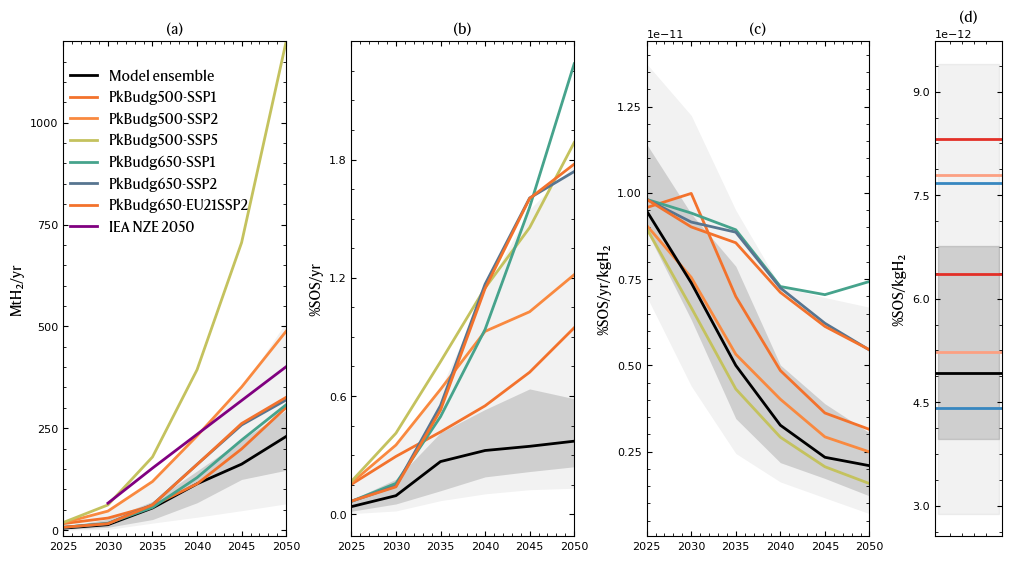

In [16]:
A,B,C,D = plt.figure(figsize=(10, 5.5),facecolor="none",layout="constrained").subplot_mosaic(
                                        "ABCD",
                                        width_ratios=[1,1,1,0.3])
axs=[B,A,C,D]
axs=[i[2] for i in axs]
years=2025:5:2050
year_index=years.-2019 
for (ax,mat,l) in  zip(axs[1:2],[ṁᴹᵗ,α.*100],["MtH₂/yr","%"])
    mins = (minimum(mat, dims=1)|>vec)[year_index]
    maxs = (maximum(mat, dims=1)|>vec)[year_index]
    q05 = quantile(mat, 0.05; dims=1)[year_index]
    q25 = quantile(mat, 0.25; dims=1)[year_index]
    q50 = median(mat; dims=1)[year_index]
    q75 = quantile(mat, 0.75; dims=1)[year_index]
    q95 = quantile(mat, 0.95; dims=1)[year_index]

    ax.plot(years, q50,color="k",label="Model ensemble",lw=2)
    # ax.fill_between(x=years, y1=mins, y2=maxs, color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(x=years, y1=q05, y2=q95, color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(x=years, y1=q25, y2=q75, color="grey",linewidth=0, alpha=0.3)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end

for (i,k,l) in zip(1:6,["yellow","orange","purple","yellow","orange","purple"],["PkBudg500-SSP1","PkBudg500-SSP2","PkBudg500-SSP5",
                                                  "PkBudg650-SSP1","PkBudg650-SSP2","PkBudg650-EU21SSP2"])
    axs[1].plot(years,ṁᴹᵗ_rmd[:,year_index][i,:]',linestyle="-",lw=2,label=l)
end

IEA_years=[2030, 2035, 2050]
IEA_vals=[66, 152, 401]#.*EJH2_to_kgH2*1.e-9
axs[1].plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="purple",linestyle="-",lw=2)
axs[1].set_xlim(2025, 2050)
axs[1].set_ylabel("MtH₂/yr", fontproperties=font_prop)
axs[1].set_ylim(-15, 1200)
axs[1].set_title("(a)", fontproperties=font_prop)

# Total allocation factor
for (i,k) in zip(1:6,["yellow","orange","purple","yellow","orange","purple"])
    axs[2].plot(years,β_rmd[:,year_index][i,:].*100,linestyle="-",lw=2)
end
axs[2].set_xlim(2025, 2050)
axs[2].set_ylabel("%SOS/yr", fontproperties=font_prop)
# axs[2].set_ylim(-0.0005.*100, 0.04.*100)
axs[2].set_title("(b)", fontproperties=font_prop)

# allocated space per kgH2 using utilitarian principle.
axs[3].set_title("(c)",fontproperties=font_prop_labels)
αᵏᵍmins = [minimum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αᵏᵍmaxs = [maximum(filter(!isnan, αᵏᵍ[:,j])) for j in 1:size(αᵏᵍ,2)][year_index]
αq(a,q) = [quantile(filter(!isnan, a[:,j]), q ) for j in 1:size(a,2)][year_index]
αᵏᵍq05 , αᵏᵍq95 = αq(αᵏᵍ,0.05),αq(αᵏᵍ,0.95) #5-95th (90%) IQR 
αᵏᵍq25 , αᵏᵍq75 = αq(αᵏᵍ,0.25),αq(αᵏᵍ,0.75) #25-75th (50%) IQR
αᵏᵍq50 = αq(αᵏᵍ,0.50)

axs[3].plot(years,βᵏᵍ_rmd[:,year_index]'.*100,linewidth=2)
axs[3].plot(years,αᵏᵍq50 .*100 ,label="Median",linewidth=2, color="k")
axs[3].fill_between(x=years, y1=αᵏᵍq05.*100, y2=αᵏᵍq95.*100, color="grey",linewidth=0, alpha=0.1) #85% proba
axs[3].fill_between(x=years, y1=αᵏᵍq25.*100, y2=αᵏᵍq75.*100, color="grey",linewidth=0, alpha=0.3) #70% proba
axs[3].set_xlim(2025, 2050)
axs[3].set_ylabel("%SOS/yr/kgH₂",fontproperties=font_prop_labels)


minvect_hr=minimum(αᵏᵍ[:,year_index],dims=1)*100|>mean
maxvect_hr=maximum(αᵏᵍ[:,year_index],dims=1)*100|>mean
q50_hr= median(αᵏᵍ[:,year_index],dims=1)*100|>mean
q05_hr = quantile(αᵏᵍ[:,year_index], 0.05, dims=1)*100|>mean
q25_hr = quantile(αᵏᵍ[:,year_index], 0.25, dims=1)*100|>mean
q75_hr = quantile(αᵏᵍ[:,year_index], 0.75, dims=1)*100|>mean
q95_hr=  quantile(αᵏᵍ[:,year_index], 0.95, dims=1)*100|>mean

axs[4].axhline([q50_hr],color="k",linestyle="-", xmin=0, xmax=1,lw=2)
axs[4].tick_params(bottom=false, labelbottom=false)
axs[4].fill_between(x=[0, 1], y1=q05_hr, y2=q95_hr, color="grey", alpha=0.1)
axs[4].fill_between(x=[0, 1], y1=q25_hr, y2=q75_hr, color="grey", alpha=0.3)
axs[4].set_ylabel("%SOS/kgH₂", fontproperties=font_prop)
axs[4].set_title("(d)", fontproperties=font_prop)
axs[4].tick_params(axis="both", top=false, bottom=false)

for (i,k) in zip(1:6,["#e32f27","#fca082","#3787c0","#e32f27","#fca082","#3787c0"])
    vect=(mean(βᵏᵍ_rmd[:,year_index],dims=2)*100)[i,:]
    axs[4].axhline([vect],color=k,linestyle="-", xmin=0, xmax=1,lw=2)
end

axs[1].yaxis.set_major_locator(tkr.MaxNLocator(integer=true, nbins=5))
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[3].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
axs[4].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, frameon=false, loc="upper center", bbox_to_anchor=(0.43, 0.97), ncol=1, prop=font_prop)
plt.savefig(respath*"summary_res.svg", bbox_inches="tight",transparent=true)
plt.savefig(respath*"summary_res.png", dpi=800,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


# **4. Climate change scenario variables**

## **4.1. Data gathering**

In [17]:
fair_ds = xr.open_dataset("/Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Publications/Journal articles/1_Natcoms/Submission/Source data/01_input/FAIR/climate_data.nc")

GSTA_fair=fair_ds.GSTA.median(dim="config").sel(layer=0,scenario="ssp119",timebounds=(2015:1:2105).-1)
GSTA_fair_10yr_avg = GSTA_fair.rolling(timebounds=50, center=true).mean()
EFR_fair= fair_ds.ERF.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
EFR_CO2_fair= fair_ds.CO2_erf.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1)
atCO2_fair= fair_ds.atco2.median(dim="config").sel(scenario="ssp119",timebounds=(2020:1:2100).-1);


In [18]:
## Data from the Annex III of the Intergovernmental Panel On Climate Change (Ipcc) (2023) Climate Change 2021 – The Physical Science Basis: Working Group I Contribution to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change. 1st edn. Cambridge University Press. Available at: https://doi.org/10.1017/9781009157896.
hist_years_erf =[1750, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2019]
hist_years_ppm = [
    1750, 1850, 1860, 1870, 1880, 1890, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935,
    1940, 1945, 1950, 1955, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
    1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
    2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019
]
ssp19_years2500 = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2200, 2300, 2400, 2500]
ssp19_years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]

hist_ppm = [
    278.3, 285.5, 286.8, 288.4, 290.4, 293.3, 296.4, 298.0, 300.0, 302.5, 304.8, 306.3, 307.1, 308.6,
    311.7, 312.7, 313.1, 314.6, 316.8, 317.5, 318.2, 318.8, 319.5, 320.0, 321.0, 321.6,
    358.2, 360.0, 361.8, 362.5, 365.5, 367.6, 368.8, 370.4, 372.4, 375.0, 376.8, 378.8,
    381.0, 382.7, 384.8, 386.3, 388.6, 390.5, 392.5, 395.2, 397.1, 399.4, 402.9, 405.0, 407.4, 409.9
]
ssp19_ppm2500 =   [414,  434,  440,  438,  431,  424,  415,  405,  394,  343,  342,  339,  337]
ssp19_ppm =   [414,  434,  440,  438,  431,  424,  415,  405,  394]
ssp126_ppm = [414, 440, 458, 469, 474, 473, 467, 457, 446, 403, 396, 389, 384]

hist_erf = [0.3, 0.33, 0.34 ,.3, 0.43, 0.48, 0.52, 0.59, 0.54, 0.42, 0.86, 1.42, 2.02, 2.23, 2.61, 2.84]
ssp19_erf = [2.81, 3.20, 3.18, 3.05, 2.88, 2.76, 2.64, 2.48, 2.33, 1.58, 1.49, 1.42, 1.38]
ssp26_erf = [2.80, 3.21, 3.48, 3.58, 3.58, 3.54, 3.42, 3.25, 3.10, 2.50, 2.30, 2.19, 2.11];
ssp19_erfCO2 =   [2.22,2.49,2.56,2.53,2.45,2.35,2.23,2.09,1.92];


In [19]:
GSTA=getVals("AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile",df=df)
RF=getVals("AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|50.0th Percentile",df=df);
GSTA_rmd=getVals("Temperature|Global Mean",df=rmd_df);

tucl=vcat(df[1:0, :],tucl_SSP2; cols = :union)
tucl_meta=tucl[:,1:4]
tucl_data=tucl[:,string.(2020:1:2100)]|>fill_missing!
tucl=hcat(tucl_meta,tucl_data);

img=vcat(df[1:0, :],img_scenarios; cols = :union)
img_meta=img[:,1:4]
img_data=img[:,string.(2020:1:2100)]|>fill_missing!
img=hcat(img_meta,img_data);
GSTA_tucl=getVals("Temperature|Global Mean",df=tucl)

GSTA_img=getVals("Temperature|Global Mean",df=img)
cumEmi_tucl=cumsum(getVals("Emissions|CO2",df=tucl),dims=2).*1e-6 # convert to GtCO2

cumEmi_img=cumsum(getVals("Emissions|CO2",df=img),dims=2).*1e-3;

Emi_tucl=getVals("Emissions|CO2",df=tucl).*1e6
Emi_img=getVals("Emissions|CO2",df=img).*1e9
Emi_rmd=getVals("Emissions|CO2",df=rmd_df).*1e9;


In [20]:
"""
IRF_CO₂
# CO2 impulse response function 


Hauglustaine, D. et al. (2022) ‘Climate benefit of a future hydrogen economy’, Communications Earth & Environment, 3(1), p. 295. Available at: https://doi.org/10.1038/s43247-022-00626-z.

"""
function IRF_CO₂(year)
    alpha_0, alpha_1, alpha_2, alpha_3 = 0.2173, 0.2240, 0.2824, 0.2763
    tau_1, tau_2, tau_3 = 394.4, 36.54, 4.304
    exponentials(year, alpha, tau) = alpha * tau * (1 - exp(-year / tau))
    return (
        alpha_0 * year
        + exponentials(year, alpha_1, tau_1)
        + exponentials(year, alpha_2, tau_2)
        + exponentials(year, alpha_3, tau_3)
    )
end
function RF_CO₂(impact,period)

    radiative_efficiency_ppb = 1.33e-5  # W/m2/ppb; 2019 background co2 concentration; IPCC AR6 Table 7.15
    
    # for conversion from ppb to kg-CO2
    M_co2 = 44.01  # g/mol
    M_air = 28.97  # g/mol, dry air
    m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

    radiative_efficiency_kg = radiative_efficiency_ppb * (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
    
    decay_multipliers = radiative_efficiency_kg * diff(IRF_CO₂.(period)) #reduction of 1 year here 80
    years_period=length(period)-1
    
    decay_matrix=zeros(years_period,years_period)
    for i in 1:1:years_period
        decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
    end
    
    return  decay_matrix.*impact[1:end-1]

end
function Conc_CO₂(impact,period)
    
    # for conversion from ppb to kg-CO2
    M_co2 = 44.01  # g/mol
    M_air = 28.97  # g/mol, dry air
    m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

    concentration_per_kg =  (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
    decay_multipliers = concentration_per_kg * diff(IRF_CO₂.(period)) #reduction of 1 year here 80
    years_period=length(period)-1
    
    decay_matrix=zeros(years_period,years_period)
    for i in 1:1:years_period
        decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
    end
    
    return  decay_matrix.*impact[1:end-1].*1e-3#ppm

end


Conc_CO₂ (generic function with 1 method)

In [21]:
# function IRF_CO₂(year)
#     # α₀, α₁, α₂, α₃ = 0.2173, 0.0259, 0.338, 0.186
#     # τ₁, τ₂, τ₃ = 172.9, 18.51, 1.186
#     α₀, α₁, α₂, α₃ = 0.2173, 0.2240, 0.2824, 0.2763
#     τ₀, τ₁, τ₂, τ₃ = 394.4, 36.54, 4.304
#     exponentials(year, α, τ) = α * τ * (1 - exp(-year / τ))
#     return α₀ * year + exponentials(year, α₁, τ₁) + exponentials(year, α₂, τ₂)+ exponentials(year, α₃, τ₃)

# end
# function RF_CO₂(impact,period)

#     radiative_efficiency_ppb = 1.33e-5  # W/m2/ppb; 2019 background co2 concentration; IPCC AR6 Table 7.15
    
#     # for conversion from ppb to kg-CO2
#     M_co2 = 44.01  # g/mol
#     M_air = 28.97  # g/mol, dry air
#     m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

#     radiative_efficiency_kg = radiative_efficiency_ppb * (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
    
#     decay_multipliers = radiative_efficiency_kg * diff(IRF_CO₂.(period)) #reduction of 1 year here 80
#     years_period=length(period)-1
    
#     decay_matrix=zeros(years_period,years_period)
#     for i in 1:1:years_period
#         decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
#     end
    
#     return  decay_matrix.*impact[1:end-1]

# end
# function Conc_CO₂(impact,period)
    
#     # for conversion from ppb to kg-CO2
#     M_co2 = 44.01  # g/mol
#     M_air = 28.97  # g/mol, dry air
#     m_atmosphere = 5.135e18  # kg [Trenberth and Smith, 2005]

#     concentration_per_kg =  (M_air / M_co2) * 1e9 / m_atmosphere  # W/m2/kg-CO2
#     decay_multipliers = concentration_per_kg * diff(IRF_CO₂.(period)) #reduction of 1 year here 80
#     years_period=length(period)-1
    
#     decay_matrix=zeros(years_period,years_period)
#     for i in 1:1:years_period
#         decay_matrix[i,i:end]=decay_multipliers[1:end+1-i]
#     end
    
#     return  decay_matrix.*impact[1:end-1].*1e-3#ppm

# end


In [22]:
Emi=getVals("Emissions|CO2",df=df).*1e9
years=2020:1:2100
period=years.-2019

## CO2 cocnentration
decay_concentration=vcat([sum(Conc_CO₂(Emi[ssp,period],period),dims=1).+409.9 for ssp in 1:size(Emi,1)]...)
decay_concentration_rmd=vcat([sum(Conc_CO₂(Emi_rmd[ssp,period],period),dims=1).+409.9 for ssp in 1:6]...)
decay_concentration_tucl = sum(Conc_CO₂(Emi_tucl,period),dims=1).+409.9
decay_concentration_img = vcat([sum(Conc_CO₂(Emi_img[ssp,period],period),dims=1).+409.9 for ssp in 1:3]...)

decay_concentration05=quantile(decay_concentration,0.05,dims=1)
decay_concentration25=quantile(decay_concentration,0.25,dims=1)
decay_concentration50=quantile(decay_concentration,0.5,dims=1)
decay_concentration75=quantile(decay_concentration,0.75,dims=1)
decay_concentration95=quantile(decay_concentration,0.95,dims=1);


## Radiative forcing
decayforcing= vcat([sum(RF_CO₂(Emi[ssp,period],period),dims=1) for ssp in 1:size(Emi,1)]...).+2.16
decayforcing_rmd= vcat([sum(RF_CO₂(Emi_rmd[ssp,period],period),dims=1) for ssp in 1:6]...).+2.16
decayforcing_tucl = sum(RF_CO₂(Emi_tucl,period),dims=1).+2.16
decayforcing_img= vcat([sum(RF_CO₂(Emi_img[ssp,period],period),dims=1) for ssp in 1:3]...).+2.16

decayforcing05=quantile(decayforcing,0.05,dims=1)
decayforcing25=quantile(decayforcing,0.25,dims=1)
decayforcing50=quantile(decayforcing,0.5,dims=1)
decayforcing75=quantile(decayforcing,0.75,dims=1)
decayforcing95=quantile(decayforcing,0.95,dims=1);


## **4.1. Comparison of model ensemble with IPCC AR6**

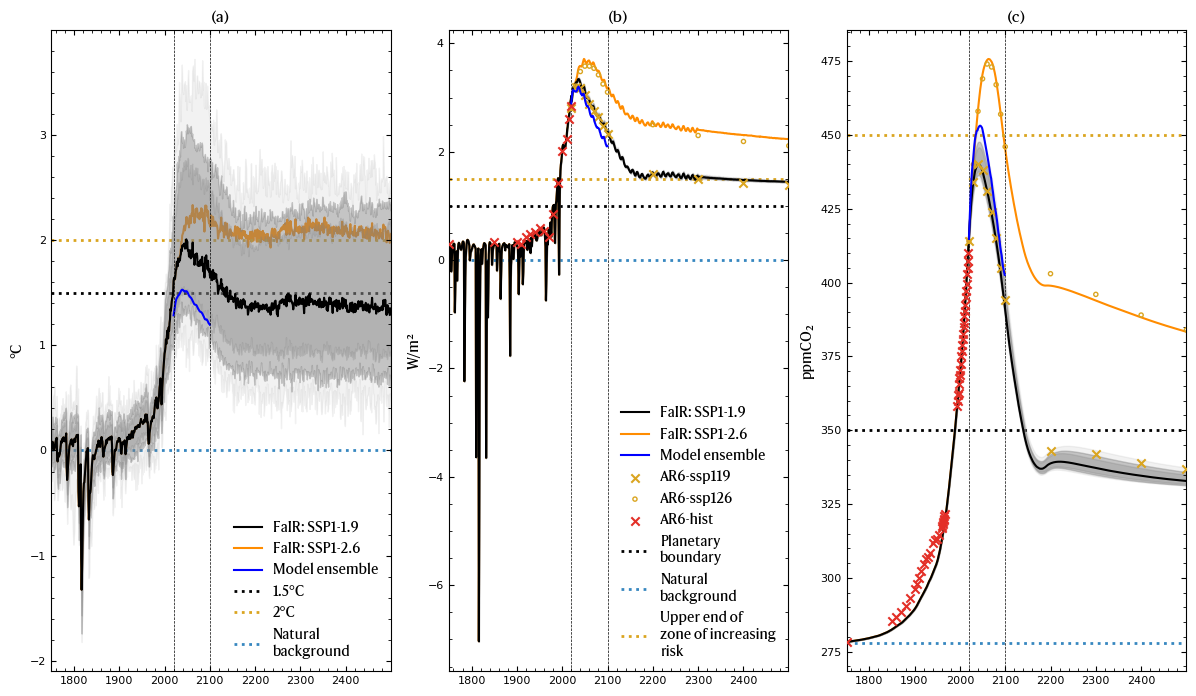

In [23]:
fig, axs = plt.subplots(1,3, figsize=(12,7))
period=fair_ds.timebounds

############ Global Surface Air Temperature Anomaly (GSTA) ############
TA=fair_ds.GSTA.sel(scenario="ssp119",layer=0)
TA26=fair_ds.GSTA.sel(scenario="ssp126",layer=0)
TAq05=TA.quantile(0.05, dim="config")
TAq16=TA.quantile(0.16, dim="config")
TAq84=TA.quantile(0.84, dim="config")
TAq95=TA.quantile(0.95, dim="config")
TAq50=TA.median(axis=1)
TAq50ssp126=TA26.median(axis=1)
TAmin=TA.min(dim="config")
TAmax=TA.max(dim="config")

TAq50.plot(ax=axs[1], label="FaIR: SSP1-1.9", color="k")
TAq50ssp126.plot(ax=axs[1], label="FaIR: SSP1-2.6", color="darkorange",zorder=0)
#GSTA background in IPCC AR6,rolling average of 10 years for the 1850-1900 period
backg=0.03899569293001064

axs[1].plot((2020:1:2100),median(GSTA.+backg,dims=1)',color="blue",label="Model ensemble")
axs[1].fill_between(period, TAmin, TAmax, alpha=0.1, color="grey")
axs[1].fill_between(period, TAq05, TAq95, alpha=0.4, color="grey")
axs[1].fill_between(period, TAq16, TAq84, alpha=0.25, color="grey")
axs[1].set_xlim(period[1], period[-1])
axs[1].set_xlabel("")
axs[1].set_title("(a)",fontproperties=font_prop_titles)
axs[1].set_ylabel("°C",fontproperties=font_prop_labels)
axs[1].axhline(1.5, ls=":",label="1.5°C", color="k",linewidth=2,zorder=0)
axs[1].axhline(2, ls=":",label="2°C", color="goldenrod",linewidth=2,zorder=0)
axs[1].axhline(0, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[1].legend(frameon=false,prop=font_prop_labels)
axs[1].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[1].axvline(2020, ls="--", color="k", linewidth=0.5)


############ Effective Radiative Forcing (ERF) ############
ERF=fair_ds.ERF.sel(scenario="ssp119")
ERF26=fair_ds.ERF.sel(scenario="ssp126")
ERFq05=ERF.quantile(0.05, dim="config")
ERFq16=ERF.quantile(0.16, dim="config")
ERFq84=ERF.quantile(0.84, dim="config")
ERFq95=ERF.quantile(0.95, dim="config")
ERFq50=ERF.median(axis=1)
ERFq50ssp126=ERF26.median(axis=1)
ERFmin=ERF.min(dim="config")
ERFmax=ERF.max(dim="config")

ERFq50.plot(ax=axs[2], label="FaIR: SSP1-1.9", color="k")
ERFq50ssp126.plot(ax=axs[2], label="FaIR: SSP1-2.6", color="darkorange",zorder=0)
#RF
axs[2].plot((2020:1:2100),median(RF,dims=1)',color="blue",label="Model ensemble",zorder=5)
axs[2].fill_between(period, ERFmin, ERFmax, alpha=0.1, color="grey")
axs[2].fill_between(period, ERFq05, ERFq95, alpha=0.4, color="grey")
axs[2].fill_between(period, ERFq16, ERFq84, alpha=0.25, color="grey")
axs[2].scatter(ssp19_years2500, ssp19_erf,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
axs[2].scatter(ssp19_years2500, ssp26_erf,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
axs[2].scatter(hist_years_erf, hist_erf,marker="x",color="#e32f27", label="AR6-hist",zorder=3)
# axs[1].fill_between(period, 0,1, alpha=0.1,color="lime",edgecolor='none',zorder=0)
# axs[1].fill_between(period, 1,1.5, alpha=0.105,color="darkorange",edgecolor='none',zorder=0)
axs[2].axhline(1, ls=":",label="Planetary\nboundary", color="k",linewidth=2,zorder=0)
axs[2].axhline(0, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[2].axhline(1.5, ls=":",label="Upper end of\nzone of increasing\nrisk", color="goldenrod",linewidth=2,zorder=0)
axs[2].set_ylabel("W/m²",fontproperties=font_prop_labels)
axs[2].set_xlabel("")
axs[2].set_xlim(period[1], period[-1])
axs[2].set_title("(b)",fontproperties=font_prop_titles)
# axs[2].legend(frameon=false,prop=font_prop_labels)
axs[2].legend(frameon=false,prop=font_prop_labels)
axs[2].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[2].axvline(2020, ls="--", color="k", linewidth=0.5)

############ Atmospheric CO2 concentration ############
CO2_conc=fair_ds.atco2.sel(scenario="ssp119")
CO2_conc26=fair_ds.atco2.sel(scenario="ssp126")
CO2_concq05=CO2_conc.quantile(0.05, dim="config")
CO2_concq16=CO2_conc.quantile(0.16, dim="config")
CO2_concq84=CO2_conc.quantile(0.84, dim="config")
CO2_concq95=CO2_conc.quantile(0.95, dim="config")
CO2_concq50=CO2_conc.median(axis=1)
CO2_concq50ssp126=CO2_conc26.median(axis=1)
CO2_concmin=CO2_conc.min(dim="config")
CO2_concmax=CO2_conc.max(dim="config")

CO2_concq50.plot(ax=axs[3], label="FaIR: SSP1-19", color="k")
CO2_concq50ssp126.plot(ax=axs[3], label="FaIR: SSP1-26", color="darkorange",zorder=0)
axs[3].plot((2020:1:2099),decay_concentration50', color="blue",zorder=5)

axs[3].set_title("(c)",fontproperties=font_prop_titles)
axs[3].fill_between(period, CO2_concmin, CO2_concmax, alpha=0.1, color="grey")
axs[3].fill_between(period, CO2_concq05, CO2_concq95, alpha=0.4, color="grey")
axs[3].fill_between(period, CO2_concq16, CO2_concq84, alpha=0.25, color="grey")
axs[3].scatter(ssp19_years2500, ssp19_ppm2500,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
axs[3].scatter(ssp19_years2500, ssp126_ppm,marker=".",edgecolor="goldenrod",color="none", label="AR6-ssp126",zorder=3)
axs[3].scatter(hist_years_ppm, hist_ppm,marker="x",color="#e32f27", label="AR6-hist",zorder=3)
axs[3].axhline(350, ls=":",label="Planetary\nboundary", color="k",linewidth=2,zorder=0)
axs[3].axhline(278, ls=":",label="Natural\nbackground", color="#3787c0",linewidth=2,zorder=0)
axs[3].axhline(450, ls=":",label="Upper end of\nzone of increasing\nrisk", color="goldenrod",linewidth=2,zorder=0)

axs[3].set_xlim(period[1], period[-1])
axs[3].set_ylabel("ppmCO₂",fontproperties=font_prop_labels)
axs[3].set_xlabel("")

axs[3].axvline(2100, ls="--", color="k", linewidth=0.5)
axs[3].axvline(2020, ls="--", color="k", linewidth=0.5)
############ Formatting ############
plt.tight_layout()
fig.savefig(respath*"climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


## **4.2. Comparison of premise scenarios with model ensemble**

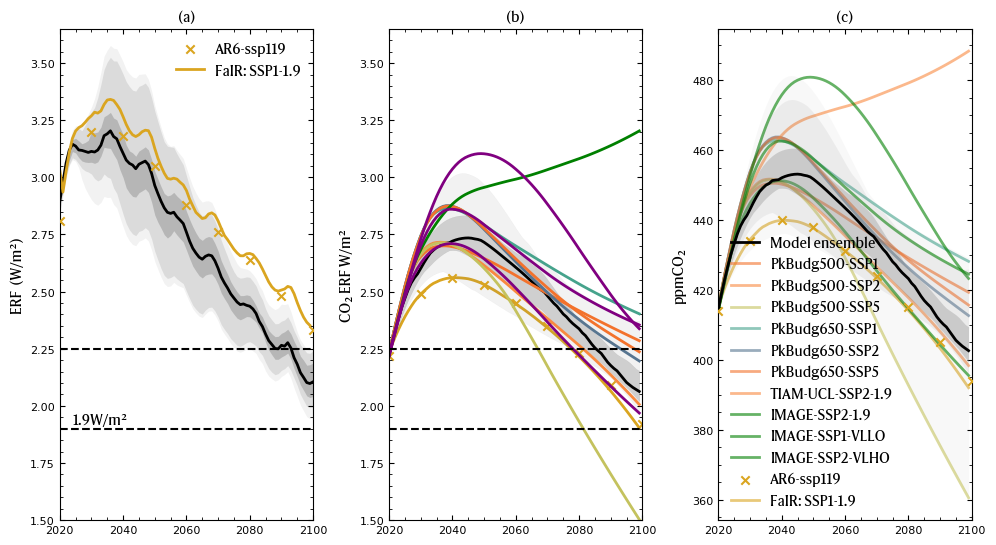

In [24]:
fig, axs = plt.subplots(1, 3,figsize=(10, 5.5))
years = 2020:1:2100
year_index= years.-2019
for (ax,mat,l) in  zip(axs,[RF],[nothing])
    mins = minimum(mat, dims=1)|>vec
    maxs= maximum(mat, dims=1)|>vec
    q05= quantile(mat, 0.05, dims=1)
    q25= quantile(mat, 0.25, dims=1)
    q50= median(mat, dims=1)    
    q75= quantile(mat, 0.75, dims=1)
    q95= quantile(mat, 0.95, dims=1)
    ax.plot(years, q50[year_index],color="k",label=l,lw=2)
    ax.fill_between(years, y1=mins[year_index], y2=maxs[year_index], color="grey",linewidth=0, alpha=0.1)
    ax.fill_between(years, y1=q05[year_index], y2=q95[year_index], color="grey",linewidth=0, alpha=0.2)
    ax.fill_between(years, y1=q25[year_index], y2=q75[year_index], color="grey",linewidth=0, alpha=0.4)
    ax.set_ylabel(l, fontproperties=font_prop)
    ax.tick_params(axis="both", direction="in")
end

## IPCC AR6 data 
### Effective Radiative Forcing (ERF)
axs[1].scatter(ssp19_years2500, ssp19_erf,marker="x",color="goldenrod", label="AR6-ssp119",zorder=3)
EFR_fair.plot(x="timebounds", ax=axs[1],label="FaIR: SSP1-1.9", lw=2, color="goldenrod")
axs[1].axhline([1.9],color="black",linestyle="--",xmax=1)
axs[1].annotate("1.9W/m²", xy=(2024, 1.92), xytext=(2024, 1.92), fontsize=10, fontproperties=font_prop)
axs[1].legend(frameon=false, prop=font_prop)
axs[1].set_ylabel("ERF  (W/m²)", fontproperties=font_prop)
axs[1].set_xlabel("")
axs[1].set_title("(a)", fontproperties=font_prop)
axs[1].set_xlim(2020, 2100)
axs[1].set_ylim(1.5, 3.65)
axs[1].axhline(2.25,color="black",linestyle="--",xmax=1)

axs[2].plot((2020:1:2099),decayforcing50',color="k",label="Model ensemble", lw=2)
EFR_CO2_fair.plot(ax=axs[2],x="timebounds", color="goldenrod", label="FaIR: SSP1-1.9",zorder=0, lw=2)
axs[2].fill_between((2020:1:2099),decayforcing05,decayforcing95,color="grey",alpha=0.1, lw=0.2)
axs[2].fill_between((2020:1:2099),decayforcing25,decayforcing75,color="grey",alpha=0.3, lw=0.2)
axs[2].set_ylabel("CO₂ ERF W/m²", fontproperties=font_prop_labels)
axs[2].plot((2020:1:2099),decayforcing_rmd',label=["PkBudg500-SSP1","PkBudg500-SSP2","PkBudg500-SSP5",
                                                  "PkBudg650-SSP1","PkBudg650-SSP2","PkBudg650-SSP5"], lw=2)
axs[2].plot((2020:1:2099),decayforcing_tucl', color="green", label="TIAM-UCL-SSP2-1.9", lw=2)
axs[2].plot((2020:1:2099),decayforcing_img', color="purple", label=["IMAGE-SSP2-1.9","IMAGE-SSP1-VLLO","IMAGE-SSP2-VLHO"], lw=2)
axs[2].scatter(ssp19_years,ssp19_erfCO2,color="goldenrod",marker="x")
axs[2].axhline(2.25,color="black",linestyle="--",xmax=1)
# axs[2].axhline(1.9, color="k", linewidth=0.5)
axs[2].set_xlim(2020, 2100)
axs[2].set_ylim(1.5, 3.65)
axs[2].set_xlabel("")
axs[2].set_title("(b)", fontproperties=font_prop)
axs[2].axhline([1.9],color="black",linestyle="--",xmax=1)

axs[3].plot((2020:1:2099),decay_concentration50', color="k",label="Model ensemble", lw=2,zorder=5)
axs[3].fill_between(x=(2020:1:2099), y1=decay_concentration05, y2=decay_concentration95, color="grey",alpha=0.1, linewidth=0,zorder=4)
axs[3].fill_between(x=(2020:1:2099), y1=decay_concentration25, y2=decay_concentration75, color="grey",alpha=0.3, linewidth=0,zorder=4)
axs[3].fill_between(x=(2020:1:2099), y1=(minimum(decay_concentration,dims=1)|>vec)', 
                                            y2=(maximum(decay_concentration,dims=1)|>vec)', 
                                            color="grey",alpha=0.05, linewidth=0)
axs[3].plot((2020:1:2099),decay_concentration_rmd',label=["PkBudg500-SSP1","PkBudg500-SSP2","PkBudg500-SSP5",
                                                            "PkBudg650-SSP1","PkBudg650-SSP2","PkBudg650-SSP5"], lw=2,alpha=0.6)
axs[3].plot((2020:1:2099),decay_concentration_tucl', label="TIAM-UCL-SSP2-1.9", lw=2,alpha=0.6)
axs[3].plot((2020:1:2099),decay_concentration_img' , label=["IMAGE-SSP2-1.9","IMAGE-SSP1-VLLO","IMAGE-SSP2-VLHO"], color="green", lw=2,alpha=0.6)
axs[3].scatter(ssp19_years,ssp19_ppm,color="goldenrod",marker="x",zorder=5,label="AR6-ssp119")
atCO2_fair.plot(ax=axs[3],x="timebounds", color="goldenrod", label="FaIR: SSP1-1.9",zorder=0, lw=2,alpha=0.6)

axs[3].set_title("(c)", fontproperties=font_prop)
axs[3].set_xlabel("")
axs[3].set_ylabel("ppmCO₂", fontproperties=font_prop_labels)
axs[3].legend(frameon=false,prop=font_prop_labels)
axs[3].set_xlim(2020, 2100)
fig.tight_layout()
fig.savefig(respath*"scenario_climate_vars.svg", bbox_inches="tight",transparent=true)
fig.savefig(respath*"scenario_climate_vars.png", dpi=800 ,bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


# **3. Allocated safe operating space**

First we load the safe operating space.

In [25]:
sos=load("../Source data/02_results/2_01_global_space/data_SOS.jld2")
𝚫𝐗ᴾᵇ,𝚫𝐗ᴰ,units,catnames=sos["𝚫𝐗ᴾᵇ"],sos["𝚫𝐗ᴰ"],sos["units"],sos["control_var"];


In [26]:
## First we need to create a set of years that fit the dimension of our assessment. 
all_years = 2020:1:2100
assessment_years = 2025:5:2050
years_to_remove=setdiff(all_years,assessment_years)
years=setdiff(all_years,years_to_remove);


$$
\boldsymbol{\omega^{b}} = \alpha \times \boldsymbol{\Delta X^{b}} \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$


When this is done, we need to broadcast these vectors into matrices to fit the dimensions of our study. We have 3 scenarios and 6 years. To respect the convention used in this work

$$
\boldsymbol{\Omega^{b}_{yq} = \alpha_{yq} \times \Delta X^{b}}  \quad \forall b \in \left\{PB, D \right\}
\tag{3}
$$

We can now perform the allocation of the safe operating space and save our results.

In [ ]:
𝚨max=maximum(αᵏᵍ[:,years.-2019],dims=1)
𝚨min=minimum(αᵏᵍ[:,years.-2019],dims=1)
𝚨q50=median(αᵏᵍ[:,years.-2019],dims=1)
δ𝛀ᴾᵇ=𝚫𝐗ᴾᵇ.*TriangularDist.(𝚨min, 𝚨max, 𝚨q50);
𝛀ᴾᵇ=𝚫𝐗ᴾᵇ*mode.(TriangularDist.(𝚨min, 𝚨max, 𝚨q50))
δ𝛀ᴰ=𝚫𝐗ᴰ.*TriangularDist.(𝚨min, 𝚨max, 𝚨q50);
𝛀ᴰ=𝚫𝐗ᴰ*mode.(TriangularDist.(𝚨min, 𝚨max, 𝚨q50));


Having defined all that we can perform a simple montecarlo simulation to estimate the allocation factors.

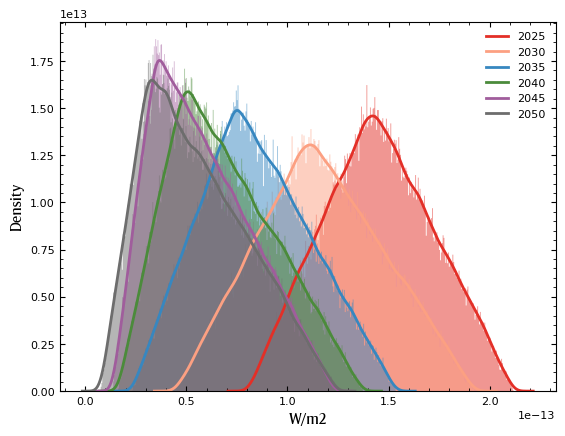

In [ ]:
# fig, ax = plt.subplots()
# category =1
# year=4
# sim=rand.(δ𝛀ᴰ,100000)
# colo= ["#e32f27","#fca082","#3787c0","#4b8b3b","#a05d9c","#6d6d6d"]

# for y in 1:6
#     ax.hist(sim[1,y], bins=300,density=true, alpha=0.5,edgecolor="none",
#             color=colo[y], histtype="stepfilled", lw=1.5)
#     kd = kde(sim[1,y])
#     ax.plot(kd.x, kd.density, color=colo[y], lw=2, label="$(years[y])")
# end
# ax.set_ylabel("Density", fontproperties=font_prop_labels)
# ax.set_xlabel(units[1], fontproperties=font_prop_labels)
# ax.legend(frameon=false)
# display(plt.gcf())
# plt.close("all")


In [29]:
@save respath*"aSOS.jld" 𝛀ᴾᵇ δ𝛀ᴾᵇ 𝛀ᴰ δ𝛀ᴰ
@save respath*"ensemble.jld" df


In [ ]:
respath*"ensemble.jld"


"../Source data/02_results/2_02_allocated_space/ensemble.jld"

In [30]:
if isfile(respath*"ensemble.xlsx")
    rm(respath*"ensemble.xlsx")
    writetable(df,workbook=respath*"ensemble.xlsx")
else    
    writetable(df,workbook=respath*"ensemble.xlsx")
end
